# Apply Batch Normalization to achieve better sustainability while training models with large number of layers

- paper: 'Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift'
- Goal is to show that it is able to omit those sophisticated initializations while training NN utilizing BatchNorm

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import random

from dataset import Tokenizer, build_names_dataset, TensorDataset
from lr_scheduler import ConstatntLr
from optim import SgdOptimizer
from train import train_step, train
from plot_activations import plot_initialization_statistics
from layers import Linear, LinearWithGain, Tanh
from model import MultiLayerPerceptron

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset preparation
- here we preparing n-grams to predict next character given previous context

In [3]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
print(', '.join(names[:5]))
print(f'total names count: {names_cnt}')

# building vocabulary and tokenizer
special_tokens = ['.']   # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
tokenizer = Tokenizer(vocab)
print(f'{vocab_size=}, {vocab=}')
print(tokenizer.encode("vlad"), tokenizer.decode([22,12,1,4]))

block_size = max(map(lambda name: len(name), names)) # represents the length of context
print(f'{block_size=}')
random.shuffle(names)
train_bound, val_bound = int(0.8*names_cnt), int(0.9*names_cnt)
train_X, train_y = build_names_dataset(names[:train_bound], tokenizer, block_size)
val_X, val_y = build_names_dataset(names[train_bound:val_bound], tokenizer, block_size)
test_X, test_y = build_names_dataset(names[val_bound:], tokenizer, block_size)
print(f'{train_X.shape=}, {train_y.shape=}, val size={val_X.shape[0]}, test size={test_X.shape[0]}')
for i in range(13):
    print(f'{"".join(tokenizer.decode(train_X[i]))} => {tokenizer.itoc[train_y[i]]}')

train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

names:
emma, olivia, ava, isabella, sophia
total names count: 32033
vocab_size=27, vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
block_size=15
train_X.shape=torch.Size([182397, 15]), train_y.shape=torch.Size([182397]), val size=22916, test size=22833
............... => j
..............j => a
.............ja => q
............jaq => u
...........jaqu => e
..........jaque => l
.........jaquel => y
........jaquely => n
.......jaquelyn => .
............... => m
..............m => a
.............ma => l
............mal => v


## Evaluation

In [4]:
@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

def print_samples(model, tokenizer, n_samples=5):
    print('\nsamples:')
    trained_samples = []
    for i in range(n_samples):
        trained_samples.append(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))
    print(','.join(trained_samples))

## Build Multi-Layer Perceptrion with batch norm

In [5]:
class BatchNorm1d:
    def __init__(self, out_features, is_training=True, momentum=0.001, eps=1e-4, device='cpu'):
        self.m = momentum
        self.eps = eps
        self.is_training = is_training
        self.gamma = torch.ones((1, out_features), requires_grad=True, device=device)
        self.beta = torch.zeros((1, out_features), requires_grad=True, device=device)
        self.running_E = torch.zeros((1, out_features), device=device)
        self.running_sigma = torch.ones((1, out_features), device=device)

    def __call__(self, X):
        if self.is_training:
            E = X.mean(dim=0, keepdims=True)
            sigma = X.std(dim=0, keepdims=True)
            norm_X = (X - E) / (sigma + self.eps)
            with torch.no_grad():
                self.running_E = (1-self.m) * self.running_E + self.m * E
                self.running_sigma = (1-self.m) * self.running_sigma + self.m * sigma
            return self.gamma * norm_X + self.beta
        else:
            norm_X = (X - self.running_E) / (self.running_sigma + self.eps)
            return self.gamma * norm_X + self.beta

    def parameters(self):
        return [self.gamma, self.beta]

    def set_training(self, is_training=True):
        self.is_training = is_training


class MlpWithBatchNorm(MultiLayerPerceptron):
    def __init__(self, vocab_size, block_size, emb_size, hidden_size, n_hidden, linear_layer=LinearWithGain, keep_intermediate_grad=False, device='cpu', gen=None):
        super().__init__(vocab_size, block_size, emb_size, hidden_size, n_hidden, linear_layer=linear_layer, keep_intermediate_grad=keep_intermediate_grad, device=device, gen=gen)
        for i in range(len(self.layers)-1, 0, -1):
            if isinstance(self.layers[i], Tanh):
                prev_linear = self.layers[i-1]
                self.layers.insert(i, BatchNorm1d(prev_linear.W.shape[1], device=device))
        for L in self.layers[:-1]:
            if isinstance(L, linear_layer):
                L.set_bias(False)

    def set_training(self, is_training=True):
        for L in self.layers:
            if isinstance(L, BatchNorm1d):
                L.set_training(is_training)

    def __delete__(self, instance):
        print("pisos")
        for L in self.layers:
            if isinstance(L, Tanh):
                del L.out
        for p in parameters():
            del p

batch_norm_model.nelement()=172969
init_t_loss=13.786580085754395, init_v_loss=13.855655670166016
layer 2 (      Tanh): mean -0.00, std 0.61, saturated: 4.57%
layer 5 (      Tanh): mean +0.00, std 0.62, saturated: 3.97%
layer 8 (      Tanh): mean +0.00, std 0.63, saturated: 3.53%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 3.20%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 3.35%
layer 17 (      Tanh): mean -0.00, std 0.64, saturated: 3.28%
layer 20 (      Tanh): mean -0.00, std 0.63, saturated: 3.39%
layer 23 (      Tanh): mean +0.00, std 0.64, saturated: 3.15%
layer 26 (      Tanh): mean +0.00, std 0.64, saturated: 3.01%
layer 29 (      Tanh): mean -0.00, std 0.63, saturated: 3.19%
layer 2 (      Tanh): mean +0.000000, std 5.639695e-02
layer 5 (      Tanh): mean -0.000000, std 4.695807e-02
layer 8 (      Tanh): mean -0.000000, std 4.185563e-02
layer 11 (      Tanh): mean -0.000000, std 3.734367e-02
layer 14 (      Tanh): mean +0.000000, std 3.277833e-02
layer 17

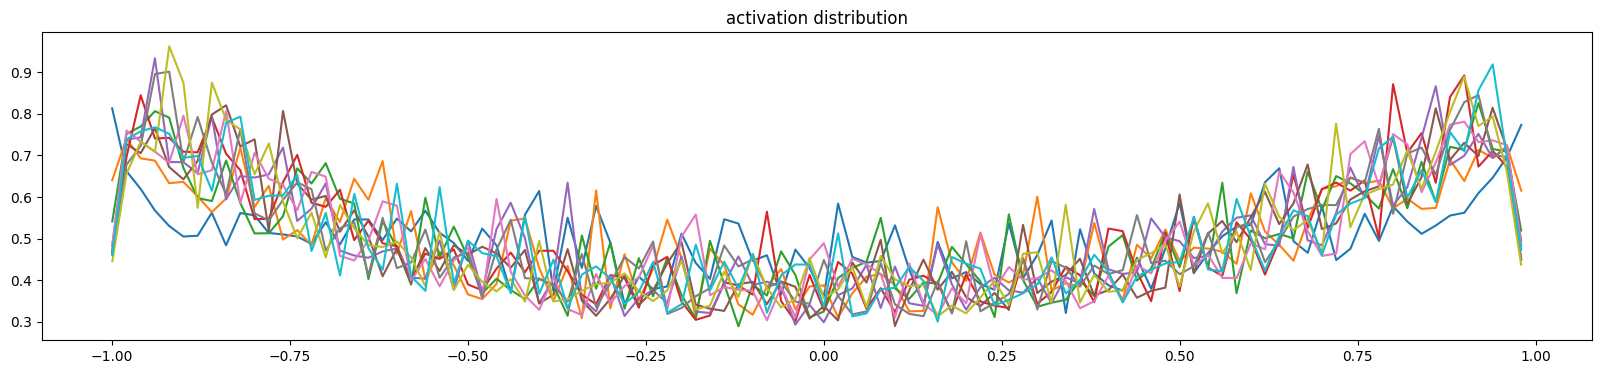

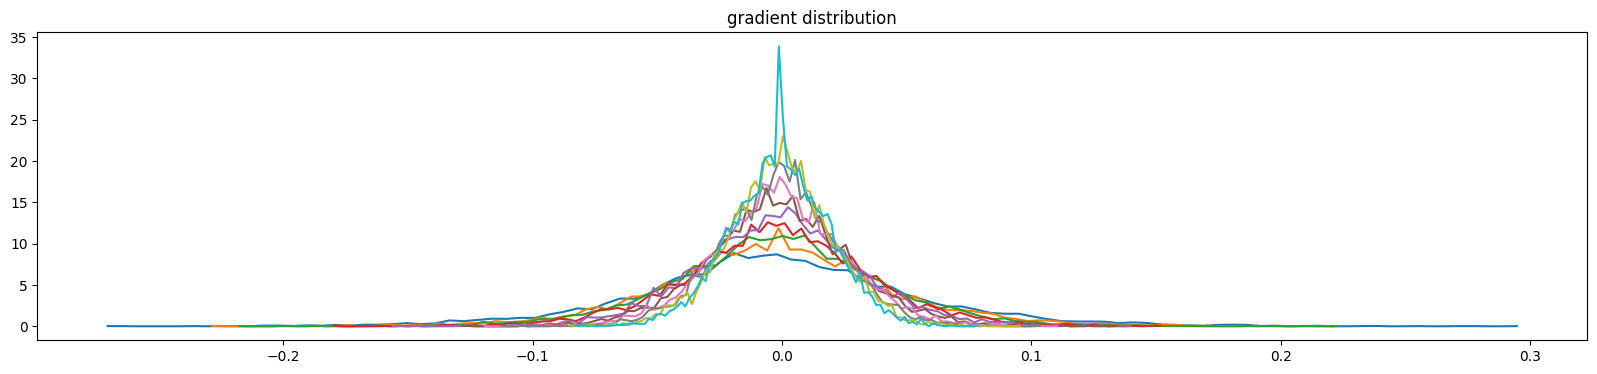

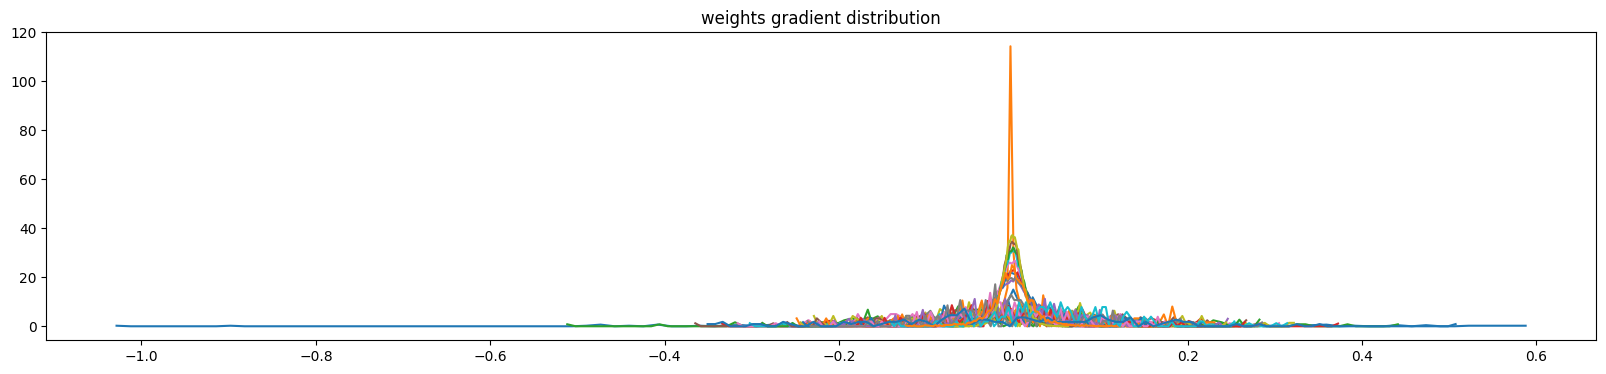

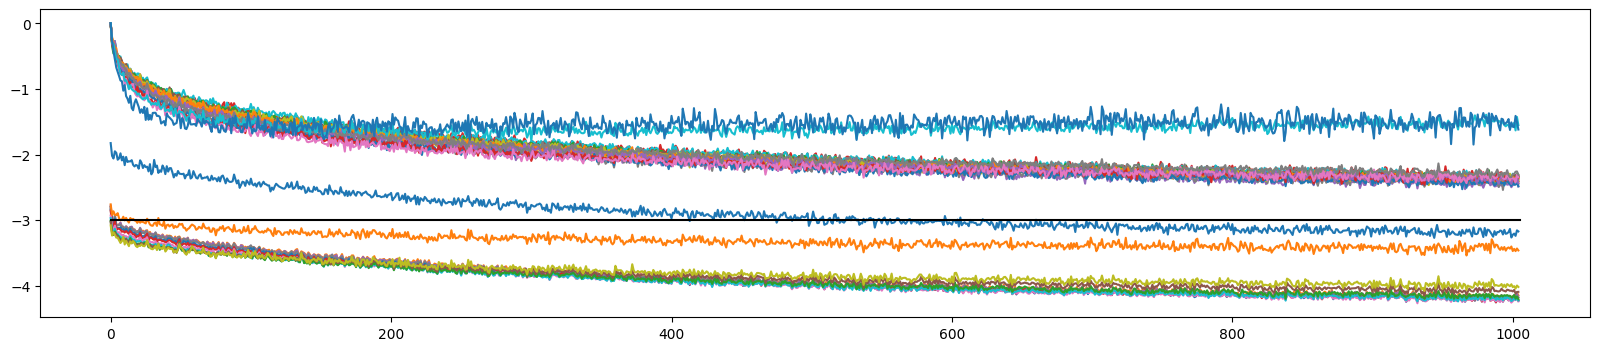

In [6]:
g = torch.Generator(device=device).manual_seed(7877)
batch_norm_model = MlpWithBatchNorm(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=10, linear_layer=Linear, keep_intermediate_grad=True, device=device, gen=g)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(batch_norm_model.parameters(), lr_provider)
print(f"{batch_norm_model.nelement()=}")
batch_norm_model.set_training(True)
plot_initialization_statistics(batch_norm_model, optimizer, train_ds, val_ds, device=device, legend=False)
del batch_norm_model
torch.cuda.empty_cache()

- even without sophisticated initialization we get nice initial Tanh saturation and gradient distribution accross the layers
- still important to strike the model's last layer to prevent confident wrong inference at initialization
- learning rate is a hyperparameter still

batch_norm_model.nelement()=369897
init_t_loss=3.2891018390655518, init_v_loss=3.28952693939209
epoch=0: cur_avg_train_loss=2.5913956549321235, cur_val_loss=2.4549367427825928
epoch=1: cur_avg_train_loss=2.422294700513033, cur_val_loss=2.393439292907715
epoch=2: cur_avg_train_loss=2.3771795441790453, cur_val_loss=2.360050678253174
epoch=3: cur_avg_train_loss=2.3485692826305784, cur_val_loss=2.337553024291992
epoch=4: cur_avg_train_loss=2.326197657264581, cur_val_loss=2.3187332153320312
epoch=5: cur_avg_train_loss=2.3082970671293115, cur_val_loss=2.303528070449829
epoch=6: cur_avg_train_loss=2.2921200192609086, cur_val_loss=2.292815923690796
epoch=7: cur_avg_train_loss=2.2791476416654612, cur_val_loss=2.280552864074707
epoch=8: cur_avg_train_loss=2.266309988598864, cur_val_loss=2.2716898918151855
epoch=9: cur_avg_train_loss=2.253575293289847, cur_val_loss=2.261969804763794
epoch=10: cur_avg_train_loss=2.2439459482160937, cur_val_loss=2.2549498081207275
epoch=11: cur_avg_train_loss=2.233

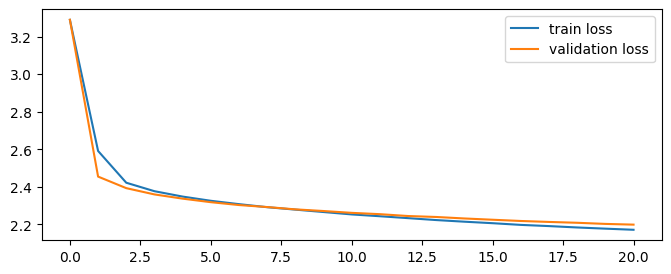

In [9]:
g = torch.Generator(device=device).manual_seed(7877)

# Train model with normalized weights in linear layers
batch_norm_model = MlpWithBatchNorm(vocab_size, block_size, emb_size=10, hidden_size=192, n_hidden=10, linear_layer=Linear, device=device, gen=g)
last_linear = batch_norm_model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(batch_norm_model.parameters(), lr_provider)
print(f"{batch_norm_model.nelement()=}")

init_t_loss = F.cross_entropy(batch_norm_model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(batch_norm_model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(batch_norm_model, train_ds, val_ds, epoches=20, batch_size=256, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

batch_norm_model.set_training(False)
print_samples(batch_norm_model, tokenizer, n_samples=15)

In [10]:
del batch_norm_model
torch.cuda.empty_cache()

## Extreme case: 50 layers

batch_norm_model.nelement()=98367
init_t_loss=3.2962052822113037, init_v_loss=3.29689884185791
epoch=0: cur_avg_train_loss=2.8691959835871073, cur_val_loss=2.7085697650909424
epoch=1: cur_avg_train_loss=2.6466039002861246, cur_val_loss=2.572139263153076
epoch=2: cur_avg_train_loss=2.546439398889956, cur_val_loss=2.515286445617676
epoch=3: cur_avg_train_loss=2.498225174645722, cur_val_loss=2.474642515182495
epoch=4: cur_avg_train_loss=2.4672901510021963, cur_val_loss=2.447373867034912
epoch=5: cur_avg_train_loss=2.44727192888086, cur_val_loss=2.4334089756011963
epoch=6: cur_avg_train_loss=2.433702686224211, cur_val_loss=2.417027473449707
epoch=7: cur_avg_train_loss=2.418322092018823, cur_val_loss=2.4003143310546875
epoch=8: cur_avg_train_loss=2.4079271576682113, cur_val_loss=2.389366626739502
epoch=9: cur_avg_train_loss=2.3996135700300734, cur_val_loss=2.3816490173339844
epoch=10: cur_avg_train_loss=2.3919885422705267, cur_val_loss=2.3738293647766113
epoch=11: cur_avg_train_loss=2.38299

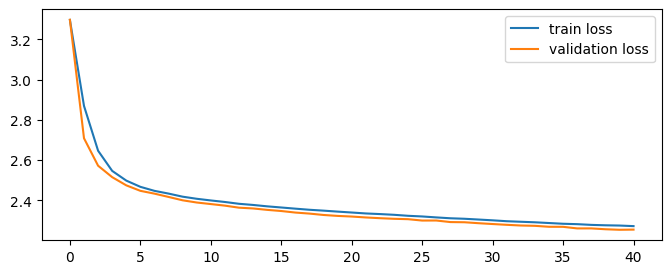

In [9]:
g = torch.Generator(device=device).manual_seed(7877)

# Train model with normalized weights in linear layers
batch_norm_model = MlpWithBatchNorm(vocab_size, block_size, emb_size=10, hidden_size=42, n_hidden=50, linear_layer=Linear, device=device, gen=g)
last_linear = batch_norm_model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(batch_norm_model.parameters(), lr_provider)
print(f"{batch_norm_model.nelement()=}")

init_t_loss = F.cross_entropy(batch_norm_model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(batch_norm_model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(batch_norm_model, train_ds, val_ds, epoches=40, batch_size=256, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

batch_norm_model.set_training(False)
print_samples(batch_norm_model, tokenizer, n_samples=15)

In [10]:
with torch.no_grad():
    test_logits = batch_norm_model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')


test_loss=tensor(2.2565)


In [11]:
del batch_norm_model
torch.cuda.empty_cache()

batch_norm_model.nelement()=104937
init_t_loss=3.296192169189453, init_v_loss=3.296137571334839
epoch=0: cur_avg_train_loss=2.7480543121214835, cur_val_loss=2.563819169998169
epoch=1: cur_avg_train_loss=2.4668680615043908, cur_val_loss=2.4106626510620117
epoch=2: cur_avg_train_loss=2.3956397365554016, cur_val_loss=2.3565287590026855
epoch=3: cur_avg_train_loss=2.357104180069826, cur_val_loss=2.3282620906829834
epoch=4: cur_avg_train_loss=2.3345929713603657, cur_val_loss=2.3030686378479004
epoch=5: cur_avg_train_loss=2.318444227603843, cur_val_loss=2.2954113483428955
epoch=6: cur_avg_train_loss=2.3044304800902977, cur_val_loss=2.287061929702759
epoch=7: cur_avg_train_loss=2.2957101309617136, cur_val_loss=2.2776377201080322
epoch=8: cur_avg_train_loss=2.286508131829753, cur_val_loss=2.265634298324585
epoch=9: cur_avg_train_loss=2.2743770815379825, cur_val_loss=2.2521162033081055
epoch=10: cur_avg_train_loss=2.268712760021108, cur_val_loss=2.2446441650390625
epoch=11: cur_avg_train_loss=2

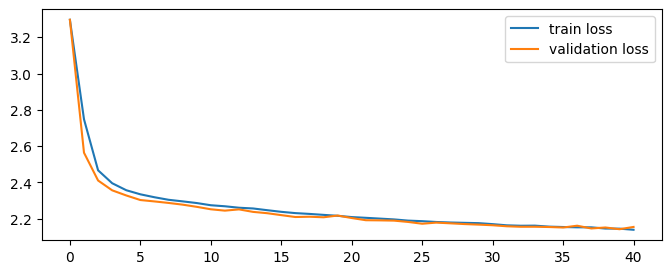

In [12]:
g = torch.Generator(device=device).manual_seed(7877)

# Train model with normalized weights in linear layers
batch_norm_model = MlpWithBatchNorm(vocab_size, block_size, emb_size=20, hidden_size=42, n_hidden=50, linear_layer=LinearWithGain, device=device, gen=g)
last_linear = batch_norm_model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0.01
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(batch_norm_model.parameters(), lr_provider)
print(f"{batch_norm_model.nelement()=}")

init_t_loss = F.cross_entropy(batch_norm_model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(batch_norm_model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(batch_norm_model, train_ds, val_ds, epoches=40, batch_size=256, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

batch_norm_model.set_training(False)
print_samples(batch_norm_model, tokenizer, n_samples=15)

### Attempt to achieve better results bu decreasing learnign rate

epoch=0: cur_avg_train_loss=2.0992392308247205, cur_val_loss=2.1350648403167725
epoch=1: cur_avg_train_loss=2.092751458349937, cur_val_loss=2.132464647293091
epoch=2: cur_avg_train_loss=2.0904067129440094, cur_val_loss=2.131051540374756
epoch=3: cur_avg_train_loss=2.088653707403956, cur_val_loss=2.1301183700561523
epoch=4: cur_avg_train_loss=2.0874448546520625, cur_val_loss=2.1295249462127686
epoch=5: cur_avg_train_loss=2.086268523130644, cur_val_loss=2.128769636154175
epoch=6: cur_avg_train_loss=2.0854855571856508, cur_val_loss=2.128650665283203
epoch=7: cur_avg_train_loss=2.0846072157837066, cur_val_loss=2.1280272006988525
epoch=8: cur_avg_train_loss=2.083949934048539, cur_val_loss=2.127330780029297
epoch=9: cur_avg_train_loss=2.0835101039346102, cur_val_loss=2.127126455307007
epoch=10: cur_avg_train_loss=2.0828979959996183, cur_val_loss=2.126746654510498
epoch=11: cur_avg_train_loss=2.0822778181140253, cur_val_loss=2.1265082359313965
epoch=12: cur_avg_train_loss=2.081814440737934, c

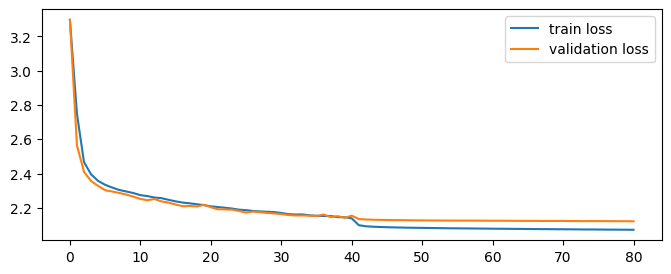

In [13]:
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(batch_norm_model.parameters(), lr_provider)
t_loss_2, v_loss_2 = train(batch_norm_model, train_ds, val_ds, epoches=40, batch_size=256, optimizer=optimizer, device=device)
t_loss.extend(t_loss_2)
v_loss.extend(v_loss_2)

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

### ... and one more time

epoch=0: cur_avg_train_loss=2.071617629049871, cur_val_loss=2.1218690872192383
epoch=1: cur_avg_train_loss=2.0714399983471607, cur_val_loss=2.1218841075897217
epoch=2: cur_avg_train_loss=2.0714426373365384, cur_val_loss=2.121901035308838
epoch=3: cur_avg_train_loss=2.0713999853227785, cur_val_loss=2.1219217777252197
epoch=4: cur_avg_train_loss=2.0714293305368945, cur_val_loss=2.1219396591186523
epoch=5: cur_avg_train_loss=2.0713843170757213, cur_val_loss=2.1219582557678223
epoch=6: cur_avg_train_loss=2.0714047657323253, cur_val_loss=2.1219751834869385
epoch=7: cur_avg_train_loss=2.071361086478909, cur_val_loss=2.1219894886016846
epoch=8: cur_avg_train_loss=2.0714480010857925, cur_val_loss=2.122004747390747
epoch=9: cur_avg_train_loss=2.0712041685992504, cur_val_loss=2.1220152378082275
epoch=10: cur_avg_train_loss=2.071318455531587, cur_val_loss=2.1220264434814453
epoch=11: cur_avg_train_loss=2.071384215756185, cur_val_loss=2.1220383644104004
epoch=12: cur_avg_train_loss=2.0713598214894

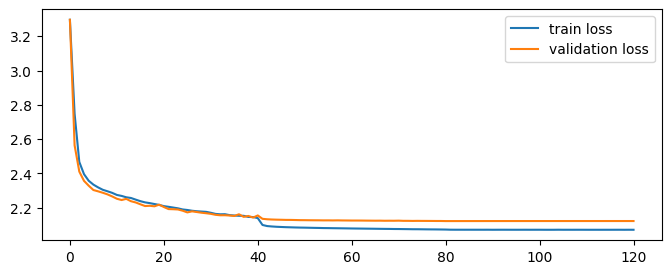

In [14]:
lr_provider = ConstatntLr(1e-5)
optimizer   = SgdOptimizer(batch_norm_model.parameters(), lr_provider)
t_loss_2, v_loss_2 = train(batch_norm_model, train_ds, val_ds, epoches=40, batch_size=256, optimizer=optimizer, device=device)
t_loss.extend(t_loss_2)
v_loss.extend(v_loss_2)

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [17]:
with torch.no_grad():
    test_logits = batch_norm_model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')


test_loss=tensor(2.1149)


In [18]:
batch_norm_model.set_training(False)
print_samples(batch_norm_model, tokenizer, n_samples=100)


samples:
shanlyle.,emrenor.,rizyn.,gawron.,laymy.,rahyna.,flam.,kensyn.,lasa.,shihlom.,arothea.,amariah.,broa.,nadyl.,xison.,syten.,edlee.,ayson.,kyndellus.,oluhed.,kilmere.,jazaria.,roban.,ralael.,same.,zyms.,caligo.,ablina.,aamar.,brielle.,daizell.,teriyah.,amwyn.,dilyne.,jetterdel.,anden.,dailyn.,elvison.,laysen.,eleolina.,wanjer.,imbrahar.,joonie.,jihani.,ninle.,karvi.,quem.,indora.,aanil.,delini.,zaher.,hiko.,ruden.,armela.,gyeber.,jare.,ansia.,quia.,gaesa.,blayzlall.,noanna.,eslynn.,ardian.,uecarzate.,daigia.,fawley.,jamary.,corey.,keeahel.,mayana.,danni.,rusan.,brivun.,jaylin.,tai.,rhelaan.,dhreen.,sasha.,kayan.,bernore.,mlairin.,imen.,yanny.,alion.,yoser.,leneenn.,shandim.,kamaen.,jaylynn.,tadoron.,aylie.,mirani.,jeviah.,amelah.,namina.,saro.,edreeardia.,edmere.,rifler.,ricci.


In [19]:
del batch_norm_model
torch.cuda.empty_cache()